### This purpose of this code is to read raw altimetry data from a server in Alaska and then ingest it into the postgres database

#### we'll use the Python library http://pysftp.readthedocs.org/en/release_0.2.8/

#### A. Arendt, S. Nimmagadda, C. Larsen

##### rev. 2015 11 17: initial creation
##### 2015 11 29: stepping through ReadLambFile from Evan's UpdateDb.py; removing str/dict distinction; trying in Pandas instead

establish the secure FTP connection:

In [14]:
import pysftp
import UpdateDb as udb
# I've set up some sample data here. We'll replace this connection with the real one after developing the code
sftp = pysftp.Connection('40.118.160.139', username='sai', password='altimetry')

#remove tryChange
The data are located in a directory 'altimetry'. In 'atimetry', there is another folder for each glacier. So we can get the list of glaciers this way:


In [15]:
glacierList = sftp.listdir('altimetry')
glacierList

['Kahiltna', 'Taku']

In [16]:
with sftp.cd('altimetry'):
     for glacierName in glacierList:
        with (sftp.cd(glacierName)):
            for fileName in sftp.listdir():
                #verify on interpreter the file about to be downloaded
                if(fileName.endswith(".output.txt")):
                    print(fileName)
                    sftp.get(fileName)
                    #lambFile = udb.ReadLambFile(fileName)

    # next, we will use the function "ReadLambFile" from the "UpdateDb.py" code to read the content of each file. 
        # see https://github.com/ice2ocean/AlaskaAltimetry/blob/master/Altimetry/UpdateDb.py
        # for now, just look at that function to see how it treats the data in the .txt files
         

Kahiltna.1994.2008.output.txt
Kahiltna.1994.2010.output.txt
Kahiltna.1994.2013.output.txt
Kahiltna.2008.2010.output.txt
Kahiltna.2008.2013.output.txt
Kahiltna.2010.2013.output.txt
Taku.1993.2014.output.txt
Taku.1993F.1999F.output.txt
Taku.1993F.2007F.output.txt
Taku.1993F.2011F.output.txt
Taku.1993F.2012F.output.txt
Taku.1999.2014.output.txt
Taku.1999F.2000S.output.txt
Taku.1999F.2007F.output.txt
Taku.1999F.2011F.output.txt
Taku.1999F.2012F.output.txt
Taku.1999S.1999F.output.txt
Taku.1999S.2000S.output.txt
Taku.1999S.2001S.output.txt
Taku.2000.2014.output.txt
Taku.2000S.2001S.output.txt
Taku.2001.2014.output.txt
Taku.2001S.2001F.output.txt
Taku.2001S.2007F.output.txt
Taku.2007.2014.output.txt
Taku.2007F.2011F.output.txt
Taku.2007F.2012F.output.txt
Taku.2011.2014.output.txt
Taku.2011F.2012F.output.txt
Taku.2012.2014.output.txt


AA: 20151119: I'm copying the ReadLambFile code here for testing. Then we can copy these back to UpdateDb.py later

NOTES: 

* providing choice to read into strings or dictionaries is not needed
* changing types from float to int is not needed I think. We can control this on ingest into Postgres anyhow
* look through this, but don't waste a lot of time on it: I think we can do much better just using Pandas (see below)

In [3]:
# import the libraries
import psycopg2
import re
import numpy as N
from time import mktime
from datetime import datetime
from time import mktime
import time
import os
import glob
import datetime as dtm
import sys

In [18]:
# for now: hard code the name of the file that would be passed to this function

lambfile = 'Taku.2012.2014.output.txt'

f = open(lambfile)

f.readline() #header trashed

#reading glacierwide data on line 1
(year1,jday1,year2,jday2,volmodel,vol25diff,vol75diff,balmodel,bal25diff,bal75diff) = [float(field) for field in f.readline().split()]

# check these were read in ok:

print(year1,jday1,year2,jday2,volmodel,vol25diff,vol75diff,balmodel,bal25diff,bal75diff)

#converting to datetime objects
date1 = dtm.datetime(int(year1), 1, 1) + dtm.timedelta(int(jday1) - 1)
date2 = dtm.datetime(int(year2), 1, 1) + dtm.timedelta(int(jday2) - 1)

#vertically binned data - READING
e=N.array([])
dz=N.array([])
dz25=N.array([])
dz75=N.array([])
aad=N.array([])
masschange=N.array([])
massbal=N.array([])
numdata=N.array([])

f.readline()  #second header trashed

for line in f:
    (e_add,dz_add,dz25_add,dz75_add,aad_add,masschange_add,massbal_add,numdata_add) = [float(field) for field in line.split()]
    e = N.append(e,e_add)
    dz = N.append(dz,dz_add)
    dz25 = N.append(dz25,dz25_add)
    dz75 = N.append(dz75,dz75_add)
    aad = N.append(aad,aad_add)
    masschange = N.append(masschange,masschange_add)
    massbal = N.append(massbal,massbal_add)
    numdata = N.append(numdata,numdata_add)

# check one of these
print(e)

2012.0 243.0 2014.0 233.0 -0.539555 0.078732 0.068873 -0.704715 0.102832 0.089955
[    0.    30.    60.    90.   120.   150.   180.   210.   240.   270.
   300.   330.   360.   390.   420.   450.   480.   510.   540.   570.
   600.   630.   660.   690.   720.   750.   780.   810.   840.   870.
   900.   930.   960.   990.  1020.  1050.  1080.  1110.  1140.  1170.
  1200.  1230.  1260.  1290.  1320.  1350.  1380.  1410.  1440.  1470.
  1500.  1530.  1560.  1590.  1620.  1650.  1680.  1710.  1740.  1770.
  1800.  1830.]


In [19]:
#e = e.astype(int)
e += (e[2]-e[1])/2    # DEALING WITH THE FACT THAT LAMB BINNING LABLES THE BOTTOM OF THE BIN AND WE WANT THE CENTER
print(e)
print(type(e))

[   15.    45.    75.   105.   135.   165.   195.   225.   255.   285.
   315.   345.   375.   405.   435.   465.   495.   525.   555.   585.
   615.   645.   675.   705.   735.   765.   795.   825.   855.   885.
   915.   945.   975.  1005.  1035.  1065.  1095.  1125.  1155.  1185.
  1215.  1245.  1275.  1305.  1335.  1365.  1395.  1425.  1455.  1485.
  1515.  1545.  1575.  1605.  1635.  1665.  1695.  1725.  1755.  1785.
  1815.  1845.]
<class 'numpy.ndarray'>


In [20]:
# numdata = numdata.astype(int)   

#GETTING GLACIER NAME FROM FILENAME
name = re.findall('(^[^\.]+)\.',os.path.basename(lambfile))[0]

dic={} 
dic['date1'] = date1
dic['date2'] = date2
dic['volmodel'] = volmodel
dic['vol25diff'] = vol25diff
dic['vol75diff'] = vol75diff
dic['balmodel'] = balmodel
dic['bal25diff'] = bal25diff
dic['bal75diff'] = bal75diff
dic['e'] = e
dic['dz'] = dz
dic['dz25'] = dz25
dic['dz75'] = dz75
dic['aad'] = aad
dic['masschange'] = masschange
dic['massbal'] = massbal
dic['numdata'] = numdata
dic['name'] = name 
# return dic

# we can query any element of the dictionary to check it:
print(dic['date1'])

2012-08-30 00:00:00


### Can we do this more simply using Pandas?

Trying the following:

In [8]:
# so we can display plots in the notebook

%matplotlib inline 
import pandas as pd

lambfile = 'Taku.2012.2014.output.txt'

glacierInfo = pd.read_csv(lambfile,sep='\t', header=None, names = ['Year1','JDay1','Year2','JDay2',
                                                          'VolModel','Vol25Diff','Vol75Diff',
                                                          'BalModel', 'Bal25Diff', 'Bal75Diff'], skiprows=1, nrows=1)

glacierData = pd.read_csv(lambfile,sep='\t', header=None, names = ['E','DZ','DZ25','DZ75',
                                                          'AAD','MassChange','MassBal','NumData'], skiprows=3)

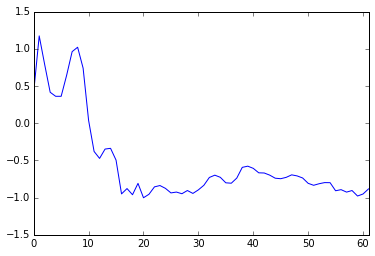

In [9]:
# now we can take advantage of the simple plotting functions in Pandas
glacierData['MassBal'].plot()

## Next steps:

* use Pandas to read the second line only, for the glacier wide info
* try passing a single row from the Pandas dataframe (a data series) to an array for the elevation dependent components
* look into Panda's ability to upload directly to SQL. With that we can replace Evan's "import_lamb_file_to_db" I think

In [12]:
#pass single row from df to array to look at elevation dependent components
#choose elevation of the bottom of the bin to determine which row to convert to an array
elevationAtBottom = 270;
matrix = (df.as_matrix())[elevationAtBottom/30]
print(matrix)

[  2.70000000e+02   8.22060000e-01  -6.77000000e-02   1.48079000e+00
   2.04930000e+06   1.51600000e-03   7.39858000e-01   2.22300000e+03]


In [16]:
glacierData['E'].as_matrix()

array([   0,   30,   60,   90,  120,  150,  180,  210,  240,  270,  300,
        330,  360,  390,  420,  450,  480,  510,  540,  570,  600,  630,
        660,  690,  720,  750,  780,  810,  840,  870,  900,  930,  960,
        990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290,
       1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620,
       1650, 1680, 1710, 1740, 1770, 1800, 1830])